## Multiclass Topic Prediction on StackExchange data

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
import pickle
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

### read in data

In [2]:
data = pd.read_csv("content_topic_prediction/Topic_prediction_data_train.txt",sep='\t',header=None)
data.columns = ['text','uid','type','timestamp']
labels = pd.read_csv("content_topic_prediction/Topic_prediction_labels_train.txt",sep='\t',header=None)
labels.columns = ['label']
data['label'] = labels['label']

In [3]:
data.head()

,text,uid,type,timestamp,label
0,distinct consubstanti translat roman missal pu...,0,Q,0.01,9
1,cathol christian power bind loos catholic beli...,0,Q,0.01,0
2,read scriptur common worship christian church ...,0,Q,0.01,9
3,accord person polit libertarian compat golden ...,0,Q,0.01,0
4,criteria cathol determin testament charact pre...,0,Q,0.01,0


### drop null values

In [4]:
data = data[(data['text'].notnull())]

### convert text data to term frequency vectors.

In [5]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000)
train_data_features = vectorizer.fit_transform(data["text"])
pickle.dump(vectorizer,open("vectorizer.p","wb" ))
features= np.array(train_data_features)

In [6]:
from sklearn.model_selection import train_test_split
x_Train, x_Test, y_Train,  y_Test= train_test_split(train_data_features,data["label"], test_size=.2, stratify = data["label"], random_state=1)

In [7]:
features

array(<96269x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 3796534 stored elements in Compressed Sparse Row format>,
      dtype=object)

### Train a support vector classifier

In [18]:
clf_LinearSVC= LinearSVC(penalty='l2')
scores_LinearSVC= cross_val_score(clf_LinearSVC, train_data_features, data["label"], cv=5, scoring='accuracy')
print("Accuracy is {0}".format(scores_LinearSVC.mean()))

Accuracy is 0.7259146122199797


### Train a Logisitic Regression classifier. 

In [20]:
clf_LR= LogisticRegression(random_state=1,C=1,penalty='l2')
scores_LR=  cross_val_score(clf_LR, train_data_features, data["label"], cv=5, scoring='accuracy')
print("Accuracy is {0}".format(scores_LR.mean()))

Accuracy is 0.7248131364637498


In [73]:
clf_NB= MultinomialNB()
scores_NB=  cross_val_score(clf_NB, train_data_features, data["label"], cv=5, scoring='accuracy')
print("Accuracy is {0}".format(scores_NB.mean()))

Accuracy is 0.734846764056418


### tune model paramaters

In [ ]:
#lr = LogisticRegression(random_state=1)
#lr_params = {'penalty':('l1','l2'),'C':[0.1,1,10],'fit_intercept':(True,False)}
#lr_cv = GridSearchCV(lr,lr_params,cv=2)
#nb = MultinomialNB()
#nb_params = {'alpha':[0.001,0.5,1]}
#nb_cv = GridSearchCV(nb,nb_params,cv=2)
#svc = LinearSVC(random_state=1)
#svc_params = {'penalty':('l1','l2'),'C':[0.1,1,10]}
#svc_cv = GridSearchCV(lr,lr_params,cv=2)

#lr_cv.fit(train_data_features,data["label"])
#nb_cv.fit(train_data_features,data["label"])
#svc_cv.fit(train_data_features,data["label"])
#print(lr_cv.best_params_)
#print(nb_cv.best_params_)
#print(svc_cv.best_params_)

In [26]:
from collections import Counter
label_counts= dict(Counter(y_Train))
print(label_counts)
print(list(label_counts.keys()))
print(list(label_counts.values()))

{4: 12750, 0: 20097, 9: 4853, 5: 6678, 6: 8222, 8: 4881, 1: 3563, 3: 4001, 7: 7056, 2: 4914}
[4, 0, 9, 5, 6, 8, 1, 3, 7, 2]
[12750, 20097, 4853, 6678, 8222, 4881, 3563, 4001, 7056, 4914]


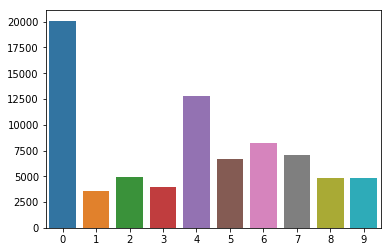

In [27]:

#UNBALANCED Class distribution
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))

### Now, train an ensemble model, get cross validation accuracy scores using 5-fold validation

In [8]:
#classifier = VotingClassifier(estimators=[('lr',LogisticRegression(random_state=1,C=1,penalty='l2')),('nb',MultinomialNB(alpha=0.001)),('svc',LinearSVC(random_state=1,C=1,penalty='l2'))],voting='hard')
classifier = VotingClassifier(estimators=[('lr',LogisticRegression()),('nb',MultinomialNB()),('svc',LinearSVC())],voting='hard')
scores = cross_val_score(classifier, x_Train, y_Train, cv=5, scoring='accuracy')

#save the classifier
#pickle.dump(classifier,open("ensemble_model.p","wb"))

In [70]:
#5-fold validation accuracy on hold out set
print("Accuracy is {0}".format(scores.mean()))

Accuracy is 0.7644998051835321


In [11]:
#Test set accuracy
from sklearn.metrics import accuracy_score
classifier.fit(x_Train,y_Train)
pred = classifier.predict(x_Test)
accuracy_score(y_Test,pred)


0.7771372182403656

In [76]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix


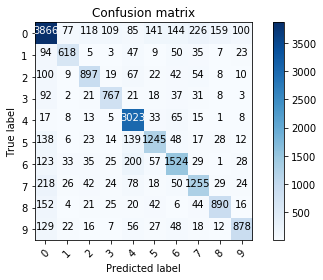

In [77]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_Test,pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9],
                      title='Confusion matrix')

### print average accuracy for ensemble.

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_Test,pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      5025
           1       0.77      0.69      0.73       891
           2       0.75      0.73      0.74      1228
           3       0.77      0.77      0.77      1000
           4       0.81      0.95      0.87      3188
           5       0.77      0.75      0.76      1670
           6       0.76      0.74      0.75      2055
           7       0.73      0.71      0.72      1764
           8       0.78      0.73      0.75      1220
           9       0.80      0.72      0.76      1213

   micro avg       0.78      0.78      0.78     19254
   macro avg       0.77      0.76      0.76     19254
weighted avg       0.78      0.78      0.78     19254



In [49]:
from sklearn.metrics import precision_recall_fscore_support
prfs=precision_recall_fscore_support(y_Test,pred, average=None)

In [51]:
prfs[0]

array([0.78433759, 0.76770186, 0.75314861, 0.76853707, 0.80915418,
       0.77233251, 0.75670308, 0.72795824, 0.77865267, 0.79673321])

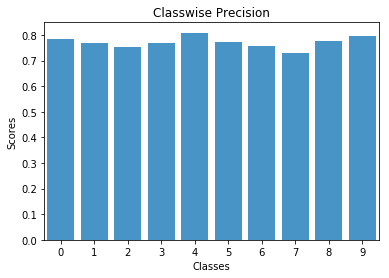

In [69]:
ax1 = plt.axes()
ax1.set_title('Classwise Precision')
ax1.set_ylabel('Scores')
ax1.set_xlabel('Classes')
sns.barplot(x=[0,1,2,3,4,5,6,7,8,9], y=prfs[0], color="#3498db" )

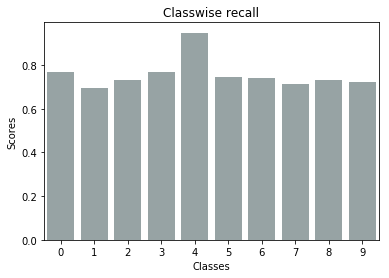

In [66]:
ax2 = plt.axes()
ax2.set_title('Classwise recall')
ax2.set_ylabel('Scores')
ax2.set_xlabel('Classes')
sns.barplot(x=[0,1,2,3,4,5,6,7,8,9], y=prfs[1], color="#95a5a6" )

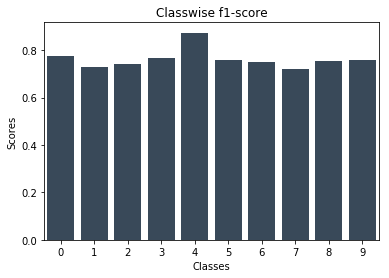

In [67]:
ax2 = plt.axes()
ax2.set_title('Classwise f1-score')
ax2.set_ylabel('Scores')
ax2.set_xlabel('Classes')
sns.barplot(x=[0,1,2,3,4,5,6,7,8,9], y=prfs[2], color="#34495e" )

In [9]:
print("Accuracy is {0}".format(scores.mean()))
#tf and logreg - .7202
#tfidf and logreg - .709
#tf and ensemble - .7512
#tfidf and ensemble - .7286
#tf and tuned ensemble - .751
#tf and ensemble and bi/tri grams - 0.7344

Accuracy is 0.7644998051835321


### Use TF-IDF scheme and include bi-grams and tri-grams features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfVect= TfidfVectorizer(min_df=.001, sublinear_tf = True,ngram_range=(1,3)).fit_transform(data["text"]).todense()

In [ ]:
tfVect.shape

In [ ]:
classifier_tid = VotingClassifier(estimators=[('lr',LogisticRegression(random_state=1,C=1,penalty='l2')),('nb',MultinomialNB(alpha=0.001)),('svc',LinearSVC(random_state=1,C=1,penalty='l2'))],voting='hard')
scores_tid = cross_val_score(classifier, tfVect, data["label"], cv=5, scoring='accuracy')

In [16]:
print("Accuracy is {0}".format(scores_tid.mean()))

Accuracy is 0.7325510633527312
